# About this code

- Author: Chenguang Wang   
- Email: samwangchenguang@gmail.com
- Project name: Generating multivariate load states using a (conditional) variational autoencoder
- Motivation: This is a project for PSCC2022 – Power Systems Computation Conference: [Homepage of the conference](https://pscc2022.pt/)
- Aim of this code: Analyze point-wise multivariate dependencies of load data
- Reference Paper: You can check our paper for more details: [Link of the paper](https://arxiv.org/abs/2110.11435)

In [20]:
# Import function lab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
# Data import
Train_load_imported = pd.read_csv("../Data/13-17_32_Train.csv", index_col=0)
Test_load_imported = pd.read_csv("../Data/13-17_32_Test.csv", index_col=0)

σ_0_1_Time_all_mu_nor_imported = pd.read_csv("../Generations/σ'_0.1_Time_all_mu_nor.csv", index_col=0)
σ_0_1_Time_all_noisy_nor_imported = pd.read_csv("../Generations/σ'_0.1_Time_all_noisy_nor.csv", index_col=0)
σ_auto_Time_all_mu_nor_β_1_imported = pd.read_csv("../Generations/σ'_auto_Time_all_mu_nor_β=1.csv", index_col=0)
σ_auto_Time_all_noisy_nor_β_1_imported = pd.read_csv("../Generations/σ'_auto_Time_all_noisy_nor_β=1.csv", index_col=0)

country_number = 32

# Data scale
max_Tr = np.max(Train_load_imported.iloc[:,:country_number], axis = 0)
min_Tr = np.min(Train_load_imported.iloc[:,:country_number], axis = 0)

Train_load_scaled = (Train_load_imported.iloc[:,:country_number]-min_Tr)/(max_Tr-min_Tr)
Test_load_scaled  = (Test_load_imported.iloc[:,:country_number]-min_Tr)/(max_Tr-min_Tr)

# Data type change
Train_load                      = Train_load_scaled.values.astype(np.float32)
Test_load                       = Test_load_scaled.values.astype(np.float32)

σ_0_1_Time_all_mu_nor           = σ_0_1_Time_all_mu_nor_imported.values.astype(np.float32)
σ_0_1_Time_all_noisy_nor        = σ_0_1_Time_all_noisy_nor_imported.values.astype(np.float32)
σ_auto_Time_all_mu_nor_β_1      = σ_auto_Time_all_mu_nor_β_1_imported.values.astype(np.float32)
σ_auto_Time_all_noisy_nor_β_1   = σ_auto_Time_all_noisy_nor_β_1_imported.values.astype(np.float32)

In [22]:
# ================== Preparation (Neuro network dessign) =======================

# ========================== Initialization fuction ============================

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

# ===================== Data dimension calcuation ==============================

# Dimension of the input
X_dim_all=np.shape(Train_load)
X_dim = X_dim_all[1]
# Dimension of the hidden layer
h_dim_1 = 24
# Dimension of the hidden layer
h_dim_2 = 16
# Dimension of the latent space
z_dim = 8

# ============================= Print the dimension ============================

print ('The dimension of the input data is: ', X_dim)
print ('The dimension of the hidden layer 1 is: ', h_dim_1)
print ('The dimension of the hidden layer 2 is: ', h_dim_2)
print ('The dimension of the latent space data is: ', z_dim)

The dimension of the input data is:  32
The dimension of the hidden layer 1 is:  24
The dimension of the hidden layer 2 is:  16
The dimension of the latent space data is:  8


In [23]:

# ================ Evaluation by CDF using autoencoder =========================

# Training condition: lr (learning rate)=0.0001; batch_size (mb_size) =64;
#                     Epoch=200,000.

# ========================== Training process ==================================

# =============================== Encoder ======================================

#Traning setting 
mb_size = 64 # Batch size
lr = 0.0001 #learning rate

# Data
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

# Layer definitions
En_W1 = tf.Variable(xavier_init([X_dim, h_dim_1]))
En_b1 = tf.Variable(tf.zeros(shape=[h_dim_1]))

En_W2 = tf.Variable(xavier_init([h_dim_1, h_dim_2]))
En_b2 = tf.Variable(tf.zeros(shape=[h_dim_2]))

En_W3 = tf.Variable(xavier_init([h_dim_2, z_dim]))
En_b3 = tf.Variable(tf.zeros(shape=[z_dim]))

# Network
def En(X): 
    h1 = tf.nn.relu(tf.matmul(X, En_W1) + En_b1)
    h2 = tf.nn.relu(tf.matmul(h1, En_W2) + En_b2)
    z = tf.matmul(h2, En_W3) + En_b3
    return z

# =============================== Decoder =======================================

# Layer definitions
De_W1 = tf.Variable(xavier_init([z_dim, h_dim_2]))  
De_b1 = tf.Variable(tf.zeros(shape=[h_dim_2]))

De_W2 = tf.Variable(xavier_init([h_dim_2, h_dim_1]))
De_b2 = tf.Variable(tf.zeros(shape=[h_dim_1]))

De_W3 = tf.Variable(xavier_init([h_dim_1, X_dim]))
De_b3 = tf.Variable(tf.zeros(shape=[X_dim]))

# Network
def De(z): 
    h1 = tf.nn.relu(tf.matmul(z, De_W1) + De_b1)
    h2 = tf.nn.relu(tf.matmul(h1, De_W2) + De_b2)
    Re_X = tf.matmul(h2, De_W3) + De_b3
    return Re_X

# ================================ Training ====================================

# Training functions
z = En(X) # Encoder 
Re_X = De(z) # Decoder

# Training loss
recon_loss= tf.reduce_mean((Re_X - X)**2)

# Solver
solver = tf.train.AdamOptimizer(lr).minimize(recon_loss)

# Seesion
sess = tf.Session() # Session definition
sess.run(tf.global_variables_initializer())

for it in range(200000): # Training process
    batch_index = np.random.choice(Train_load.shape[0], size=mb_size, replace=False)
    _, loss = sess.run([solver, recon_loss], feed_dict={X: Train_load[batch_index]})
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss_training_set: {:.4}'. format(loss))      
        #Averagr Reconstructed generated data
        Test_Re_er_mean = sess.run(recon_loss, feed_dict={X: Test_load})
        print('Loss_testing_set: {:.4}'. format(Test_Re_er_mean))  
        print()
print("Training Finished!") 

#Save the reslut    
saver = tf.train.Saver() 
saver.save(sess, './filename.chkp') 

# Session Recover
sess = tf.Session()
saver = tf.train.Saver()                                                     
saver.restore(sess, 'filename.chkp')


Iter: 0
Loss_training_set: 0.3084
Loss_testing_set: 0.3537

Iter: 1000
Loss_training_set: 0.01483
Loss_testing_set: 0.01522

Iter: 2000
Loss_training_set: 0.01009
Loss_testing_set: 0.0106

Iter: 3000
Loss_training_set: 0.01
Loss_testing_set: 0.009405

Iter: 4000
Loss_training_set: 0.007189
Loss_testing_set: 0.008034

Iter: 5000
Loss_training_set: 0.006937
Loss_testing_set: 0.006629

Iter: 6000
Loss_training_set: 0.005143
Loss_testing_set: 0.005514

Iter: 7000
Loss_training_set: 0.004867
Loss_testing_set: 0.004894

Iter: 8000
Loss_training_set: 0.004193
Loss_testing_set: 0.004471

Iter: 9000
Loss_training_set: 0.004141
Loss_testing_set: 0.004256

Iter: 10000
Loss_training_set: 0.004148
Loss_testing_set: 0.004082

Iter: 11000
Loss_training_set: 0.004369
Loss_testing_set: 0.003925

Iter: 12000
Loss_training_set: 0.003969
Loss_testing_set: 0.003721

Iter: 13000
Loss_training_set: 0.003178
Loss_testing_set: 0.003477

Iter: 14000
Loss_training_set: 0.00338
Loss_testing_set: 0.003261

Iter: 1

Iter: 121000
Loss_training_set: 0.001814
Loss_testing_set: 0.001967

Iter: 122000
Loss_training_set: 0.001854
Loss_testing_set: 0.001969

Iter: 123000
Loss_training_set: 0.002033
Loss_testing_set: 0.001969

Iter: 124000
Loss_training_set: 0.001941
Loss_testing_set: 0.001964

Iter: 125000
Loss_training_set: 0.00248
Loss_testing_set: 0.001959

Iter: 126000
Loss_training_set: 0.002063
Loss_testing_set: 0.001965

Iter: 127000
Loss_training_set: 0.002103
Loss_testing_set: 0.001959

Iter: 128000
Loss_training_set: 0.002159
Loss_testing_set: 0.001957

Iter: 129000
Loss_training_set: 0.002203
Loss_testing_set: 0.001966

Iter: 130000
Loss_training_set: 0.001853
Loss_testing_set: 0.001949

Iter: 131000
Loss_training_set: 0.00206
Loss_testing_set: 0.001954

Iter: 132000
Loss_training_set: 0.001912
Loss_testing_set: 0.001956

Iter: 133000
Loss_training_set: 0.00217
Loss_testing_set: 0.00196

Iter: 134000
Loss_training_set: 0.001994
Loss_testing_set: 0.001963

Iter: 135000
Loss_training_set: 0.0021

In [24]:
#========================(1) Caculate the reconstruction errors=================
# Reconstructed training data 
Train_load_Re_er = sess.run(Re_X, feed_dict={X: Train_load})
# Mean square value of each training residual  
Train_load_Re_er_list = np.mean((Train_load - Train_load_Re_er)**2, axis=1)

# Reconstructed testing data 
Test_load_Re_er = sess.run(Re_X, feed_dict={X: Test_load})
# Mean square value of each testing residual  
Test_load_Re_er_list = np.mean((Test_load - Test_load_Re_er)**2, axis=1)

# Reconstructed generated data （CVAE; auto σ'; noisy）
σ_auto_Time_all_noisy_nor_β_1_Re_er = sess.run(Re_X, feed_dict={X: σ_auto_Time_all_noisy_nor_β_1}) 
# Mean square value of each generated residual
σ_auto_Time_all_noisy_nor_β_1_Re_er_list = np.mean((σ_auto_Time_all_noisy_nor_β_1 - σ_auto_Time_all_noisy_nor_β_1_Re_er)**2, axis=1)

# Reconstructed generated data (CVAE; σ'=0.1; noisy)
σ_0_1_Time_all_noisy_nor_Re_er = sess.run(Re_X, feed_dict={X: σ_0_1_Time_all_noisy_nor}) 
# Mean square value of each generated residual
σ_0_1_Time_all_noisy_nor_Re_er_list = np.mean((σ_0_1_Time_all_noisy_nor - σ_0_1_Time_all_noisy_nor_Re_er)**2, axis=1)

# Reconstructed generated data (CVAE; auto σ'; Noise free)
σ_auto_Time_all_mu_nor_β_1_Re_er = sess.run(Re_X, feed_dict={X: σ_auto_Time_all_mu_nor_β_1}) 
# Mean square value of each generated residual
σ_auto_Time_all_mu_nor_β_1_Re_er_list = np.mean((σ_auto_Time_all_mu_nor_β_1 - σ_auto_Time_all_mu_nor_β_1_Re_er)**2, axis=1)

# Reconstructed generated data (CVAE; σ'=0.1; Noise free)
σ_0_1_Time_all_mu_nor_Re_er = sess.run(Re_X, feed_dict={X: σ_0_1_Time_all_mu_nor}) 
# Mean square value of each generated residual
σ_0_1_Time_all_mu_nor_Re_er_list = np.mean((σ_0_1_Time_all_mu_nor - σ_0_1_Time_all_mu_nor_Re_er)**2, axis=1)

#======(2) Caculate the fractions according to specific reconstruction error====

# Training set 
Train_load_Re_er_list_stored = np.sort(Train_load_Re_er_list)
Train_load_Re_er_list_fraction = np.array(range(len(Train_load_Re_er_list)))/float(len(Train_load_Re_er_list))

# Testing set 
Test_load_Re_er_list_stored = np.sort(Test_load_Re_er_list)
Test_load_Re_er_list_fraction = np.array(range(len(Test_load_Re_er_list)))/float(len(Test_load_Re_er_list))

# Noisy generation set （CVAE; auto σ'; noisy）
σ_auto_Time_all_noisy_nor_β_1_Re_er_list_stored = np.sort(σ_auto_Time_all_noisy_nor_β_1_Re_er_list)
σ_auto_Time_all_noisy_nor_β_1_Re_er_list_fraction = np.array(range(len(σ_auto_Time_all_noisy_nor_β_1_Re_er_list)))/float(len(σ_auto_Time_all_noisy_nor_β_1_Re_er_list))
    
# Noisy generation set (CVAE; σ'=0.1; noisy)
σ_0_1_Time_all_noisy_nor_Re_er_list_stored = np.sort(σ_0_1_Time_all_noisy_nor_Re_er_list)
σ_0_1_Time_all_noisy_nor_Re_er_list_fraction = np.array(range(len(σ_0_1_Time_all_noisy_nor_Re_er_list)))/float(len(σ_0_1_Time_all_noisy_nor_Re_er_list))

# Noise free generation set (CVAE; auto σ'; Noise free)
σ_auto_Time_all_mu_nor_β_1_Re_er_list_stored = np.sort(σ_auto_Time_all_mu_nor_β_1_Re_er_list)
σ_auto_Time_all_mu_nor_β_1_Re_er_list_fraction = np.array(range(len(σ_auto_Time_all_mu_nor_β_1_Re_er_list)))/float(len(σ_auto_Time_all_mu_nor_β_1_Re_er_list))

# Noise free generation set (CVAE; σ'=0.1; Noise free)
σ_0_1_Time_all_mu_nor_Re_er_list_stored = np.sort(σ_0_1_Time_all_mu_nor_Re_er_list)
σ_0_1_Time_all_mu_nor_Re_er_list_fraction = np.array(range(len(σ_0_1_Time_all_mu_nor_Re_er_list)))/float(len(σ_0_1_Time_all_mu_nor_Re_er_list))

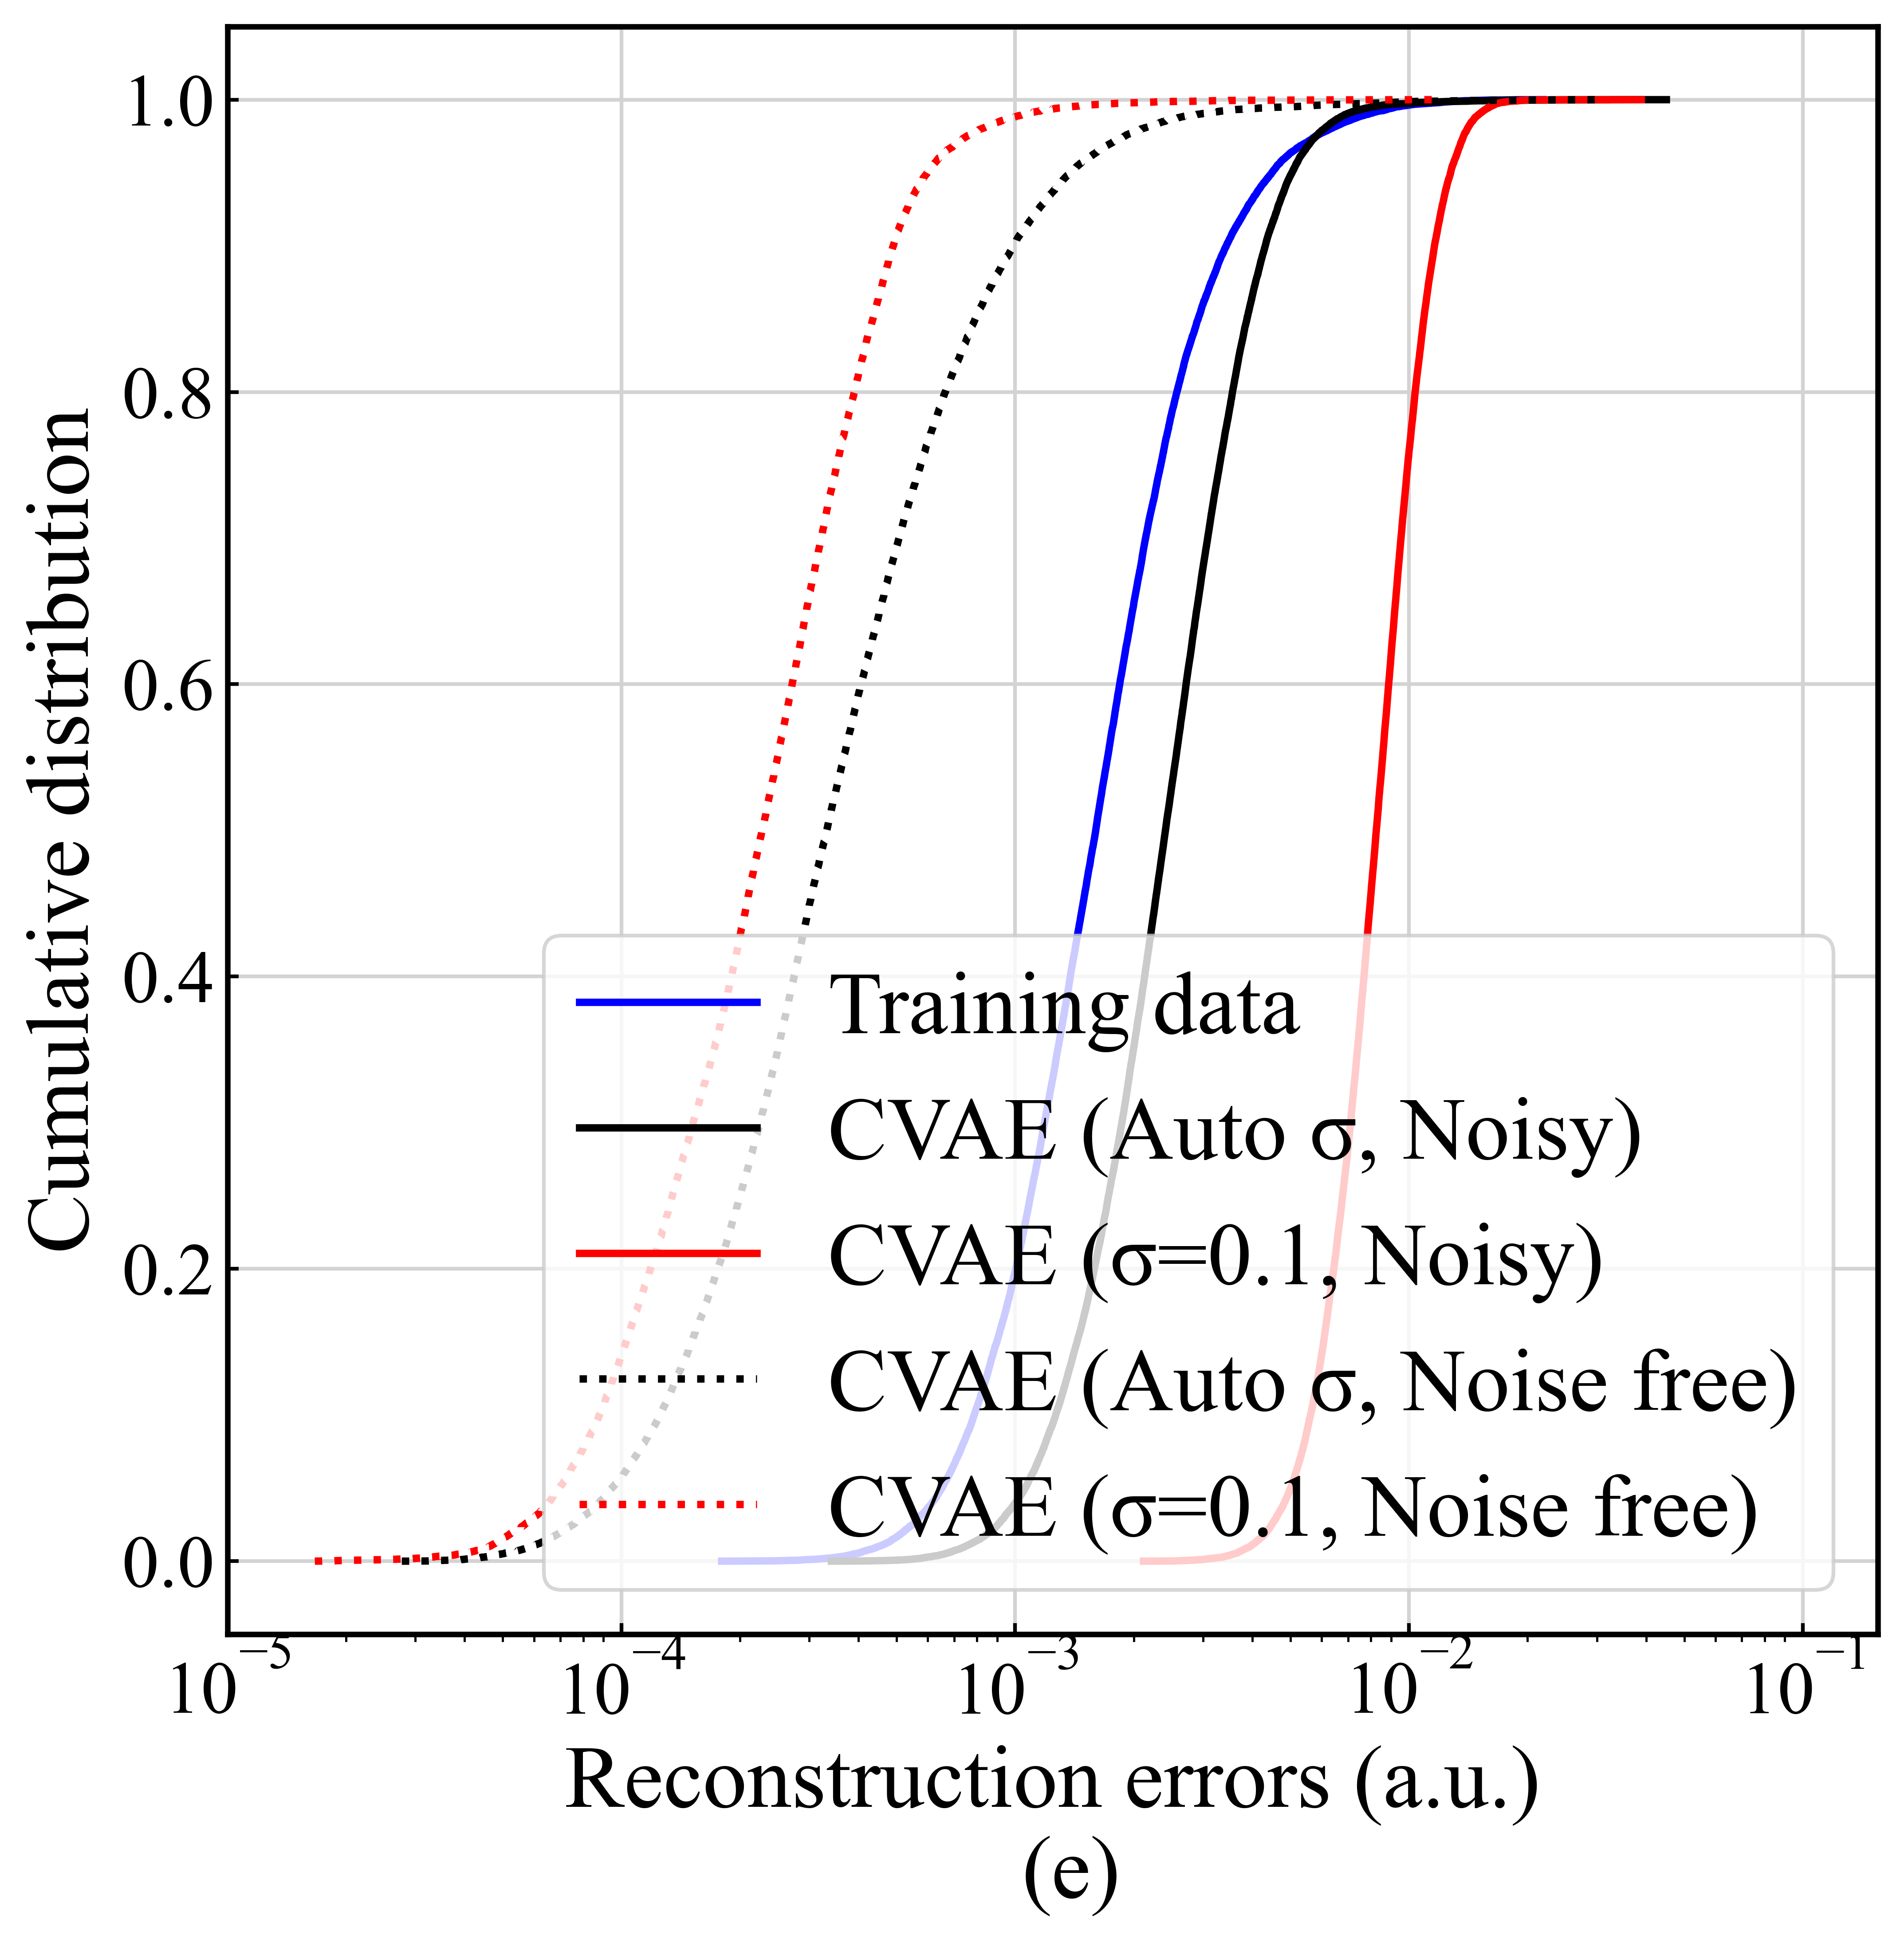

In [32]:
#------------------Set figure--------------------
# figure size
plt.figure(figsize=(8,8))
# Set dpi
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.dpi'] = 600
# set frame
bwith = 1.5
TK = plt.gca() 
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)

#------------------font--------------------------
font = {'family' : 'Times New Roman',
'weight' : 'normal','size': 24}

#------------------set tick----------------------
ax = plt.gca()
ax.tick_params(direction='in', length=3, width=1)

#------------------ tick labelel ----------------
ax = plt.gca()
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
tick_lable_size=20
ax.set_xscale('log')

#----------------- set gird width --------------
gridwidth=1

#---------------- set legend size --------------
legend_size=24

#----------------- set line width ---------------
line_width=2


plt.plot(Train_load_Re_er_list_stored, Train_load_Re_er_list_fraction, color='b',linestyle='-',
         lw=line_width, label='Training data')
#plt.plot(Test_load_Re_er_list_stored, Test_load_Re_er_list_fraction, color='b',linestyle='--',
#         lw=line_width, label='Test data')


# Noisy Generation set （CVAE auto noisy）
plt.plot(σ_auto_Time_all_noisy_nor_β_1_Re_er_list_stored, σ_auto_Time_all_noisy_nor_β_1_Re_er_list_fraction, color='k',linestyle='-',
         lw=line_width, label='CVAE (Auto σ, Noisy)')

# Averaged Generation set (CVAE set noisy)
plt.plot(σ_0_1_Time_all_noisy_nor_Re_er_list_stored, σ_0_1_Time_all_noisy_nor_Re_er_list_fraction, color='r',linestyle='-',
         lw=line_width, label='CVAE (σ=0.1, Noisy)')

# Noisy Generation set （CVAE auto mu）
plt.plot(σ_auto_Time_all_mu_nor_β_1_Re_er_list_stored, σ_auto_Time_all_mu_nor_β_1_Re_er_list_fraction, color='k',linestyle=':',
         lw=line_width, label='CVAE (Auto σ, Noise free)')


plt.plot(σ_0_1_Time_all_mu_nor_Re_er_list_stored, σ_0_1_Time_all_mu_nor_Re_er_list_fraction, color='r',linestyle=':',
         lw=line_width, label='CVAE (σ=0.1, Noise free)')

#---------------------------------------------------------------------------------
#---------------------------------------------------------------------------------
#---------------------------------------------------------------------------------


# ticks and grids
plt.xticks(fontproperties = 'Times New Roman',size=tick_lable_size, weight = 'normal')
plt.yticks(fontproperties = 'Times New Roman',fontsize=tick_lable_size, weight = 'normal')
plt.grid(color='lightgrey', linestyle='-', linewidth=gridwidth, axis='y')
plt.grid(color='lightgrey', linestyle='-', linewidth=gridwidth, axis='x')

# Notations
plt.xlabel('Reconstruction errors (a.u.)',font)
plt.ylabel('Cumulative distribution',font)
plt.legend(loc='best',prop={'family' : 'Times New Roman','weight' : 'normal','size': legend_size})

plt.text(0.00104, -0.23,'(e)',font)
plt.xlim(0.00001,0.155)

plt.show()